# Building Fast Linear Models for Astronomical Noise and Signal

**What is this?**

There's lots of information online and in text books about linear algebra. This is a collection of that information with context that's quite specific to astronomy, meaning that we're going to be building towards explorations of real data, how to build models for actual problems, and discussing how some published noise models in astronomy work. Fitting linear models is how I do any low-grade 'magic' in astronomy, so I want to put some thoughts down to enable other people to do the same.

## Some background

In astronomy data we often have multiple signals both from our astrophysical objects of interest and some systematic noise terms. We might be looking at

- 1D time series data
- 2D imaging data
- 3D data of images over time
- Higher dimensional data from catalogs

And we frequently want to remove some **systematics**, to get our best understanding of the truth. "Systematics" is an astronomy catch-all term that might mean something like

- A systematic offset in image frames due to sky background
- A systematic and predictable signal in our time-series data due to thermal changes in an instrument
- A systematic increase in brightness in a spectrum at the faint end

And many others.

So how do we get the true flux of a star in an image with a systematic brightness? How do we detrend our noisy time series to remove the impact of thermal changes and preserve the true signal? How do we get accurate spectra?

And, crucially, how do we do it fast.

We're going to have to come up with some **model** for our data. This means modeling our systematics, and any astrophysical signal that's in our data, at the same time. We're going to do this with a **linear model**.

### A side note on some references you might find useful

[Python Programming And Numerical Methods: A Guide For Engineers And Scientists](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter14.00-Linear-Algebra-and-Systems-of-Linear-Equations.html) has an excellent chapter on linear algebra. You might want to start here, and then check that out, or you might want to start there and come back here.

### A quick sidenote on some conventions here

We're going to dive into some mathematical representations here so I'm going to write down some examples of our conventions

The font face will be used to express variables as:

- $a$ : Lowercase italics are a single numeric value
- $\mathbf a$: Lowercase bold are vectors
- $\mathbf A$: Uppercase bold are matrices

I'm going to use this convention a lot in this document, so make sure you look out for this in what follows!

We'll try to follow this convention as much as possible in Python. Unfortunately we can't bold variables, so we'll use the slightly modified:

```python
# lowercase letter and a number, single valued variable
a0 = 1.1
# lowercase letter, vector
a = [0, 0, 0, 0.1, 0, 0]
# uppercase letter, matrix
A = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
```



## Writing down sets of linear equations.

In this section, we're going to write down some linear equations using vector and matrix notation. Once we're comfortable with this we'll move onto solving equations.

Linear models are quite useful because they're simple to build and will be simple to solve. Let's look at what one is, in this context. Here's an example of a linear model:

$\mathbf y = m \mathbf x + c$

Here the model $\mathbf y$ (sometimes called the dependent variable) is given by a vector $\mathbf x$ (sometimes called a regressor) some multiplicative factor (sometimes called a weight $m$ and an offset $c$. 

Let's make a model where any "y" value $y_i$ is given by 2 times the "x" value $x+i$ plus 3.

$\mathbf y = 2 \mathbf x + 3$

#### A note about noise.

The true model above is better given as 

$\mathbf y = m \mathbf x + c + \mathbf{\epsilon}$

where $\mathbf{\epsilon}$ is a noise term.  For now, we're going to drop this term, and in all this work we're going to assume that the noise is a Normal (Gaussian) noise distribution. We'll come back to this, don't worry.

### What do you mean a "linear" model.

Above I told you $\mathbf y = m \mathbf x + c$ was a linear model, let's talk about what I mean by that, in this context.

To fit my data, I want to build some **system of linear equations**, which are made up of regressors and shared **variables**. Here's a set of linear equations that have the same variables stored in the two elemenet vector $\mathbf w$


$y_0 = w_0 \cdot x_0 + w_1$

$y_1 = w_0 \cdot x_1 + w_1$

$y_2 = w_0 \cdot x_2 + w_1$

This is linear because all these equations share the same variable $\mathbf w$. The below equation is not linear

$\mathbf y = w_0 \cdot w_1 \cdot \mathbf{x} + w_2$

because here's not a single solution for $w_0$ and $w_1$. 

## Matrix Notation

Matrix notation is going to become helpful for us in this workbook. Let's express the above set of linear equations as a matrix multiplication. 

$ \mathbf y = \begin{bmatrix} x_0 & 1 \\ x_1 & 1 \\ x_2 & 1 \end{bmatrix} \cdot \mathbf w$

where

$\mathbf w = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$


We could also write the first equation ($\mathbf y = 2 \mathbf x + 3$) as a matrix multiplication

$\mathbf y = \mathbf A \cdot \mathbf w$

Where 

$ \mathbf w = \begin{bmatrix} 2 & 3 \end{bmatrix}$

and

$ \mathbf A = \begin{bmatrix} x_0 & 1 \\ x_1 & 1 \\ x_2 & 1 \\ .. & .. \\ x_n & 1 \end{bmatrix}$


$ \mathbf y = \mathbf A \cdot \mathbf w = \begin{bmatrix} x_0 & 1 \\ x_1 & 1 \\ x_2 & 1 \\ .. & ..\\ x_n & 1 \end{bmatrix} \cdot \begin{bmatrix} 2 \\ 3 \end{bmatrix}$


Putting in some values for x we find:

$ \begin{bmatrix} 3 & 5 & 7 \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 1 & 1 \\ 2 & 1 \end{bmatrix} \cdot \begin{bmatrix} 2 \\ 3 \end{bmatrix}$

Let's implement this in `numpy`.

In [2]:
import numpy as np
# Vector of x
x = np.arange(3)
# Matrix consisting of x, and a column of ones
A = np.vstack([x, x**0]).T
w = np.asarray([2, 3])
y = A.dot(w)


print('A:\n', A)
print('w:\n',  w)
print('y:\n', y)

A:
 [[0 1]
 [1 1]
 [2 1]]
w:
 [2 3]
y:
 [3 5 7]


### Bigger Lienar Models
So long as we can write our model as something that is a set of column vector regressors with a shared set of weights, we are writing a linear model that we can solve. Your model will look like this:

$y = A \cdot w$

$\mathbf{A} = \begin{bmatrix} x_{0,0} & x_{0,1} & x_{0,2} & .. & x_{0,n} \\
x_{1,0} & x_{1,1} & x_{1,2} & .. & x_{1,n} \\
x_{2,0} & x_{2,1} & x_{2,2} & .. & x_{2,n} \\
.. & .. & .. & .. & .. \\
x_{m,0} & x_{m,1} & x_{m,2} & .. & x_{m,n} \\\end{bmatrix} $

$\mathbf{w} = \begin{bmatrix} w_{0}\\ w_{1}\\ w_{2} \\..\\ w_{n}\end{bmatrix} $

$ \begin{bmatrix} y_{0}\\ y_{1}\\ y_{2} \\..\\ y_{n}\end{bmatrix} = \begin{bmatrix} x_{0,0} & x_{0,1} & x_{0,2} & .. & x_{0,n} \\
x_{1,0} & x_{1,1} & x_{1,2} & .. & x_{1,n} \\
x_{2,0} & x_{2,1} & x_{2,2} & .. & x_{2,n} \\
.. & .. & .. & .. & .. \\
x_{m,0} & x_{m,1} & x_{m,2} & .. & x_{m,n} \\\end{bmatrix} \cdot \begin{bmatrix} w_{0}\\ w_{1}\\ w_{2} \\..\\ w_{n}\end{bmatrix}$

A higher order polynomial is a set of linear equations. For example, let's imagine we have a vector of times $\mathbf{t}$ for some time series. You can write a $n$th order polynomial in this "time" variable as

$ \mathbf{y} = \begin{bmatrix} t_{0}^0 & t_{0}^1 & t_{0}^2 & .. & t_{0}^n \\
t_{1}^0 & t_{1}^1 & t_{1}^2 & .. & t_{1}^n \\
t_{2}^0 & t_{2}^1 & t_{2}^2 & .. & t_{2}^n \\
.. & .. & .. & .. & .. \\
t_{m}^0 & t_{m}^1 & t_{m}^2 & .. & t_{m}^n \\\end{bmatrix} \cdot \begin{bmatrix} w_{0}\\ w_{1}\\ w_{2} \\..\\ w_{n}\end{bmatrix}$

For a 3rd order polynomial and a vector $\mathbf t$ with four entries [6, 7, 8, 9] this looks like

$\mathbf{t} = \begin{bmatrix} 6 \\ 7 \\ 8 \\ 9 \\10\end{bmatrix} $

$ \mathbf{y} = \begin{bmatrix} 1 & 6 & 6^2 & 6^3 \\
1 & 7 & 7^2 & 7^3 \\
1 & 8 & 8^2 & 8^3 \\
1 & 9 & 9^2 & 9^3 \\
1 & 10 & 10^2 & 10^3 \\\end{bmatrix} \cdot \begin{bmatrix} w_{0}\\ w_{1}\\ w_{2}\\w_{3}\end{bmatrix}$

This is still a linear set of equations, even though we have a higher order polynomial, because the equations (each row) share the same $\mathbf{w}$ vector. 

### Linear equations with higher dimensions

At the moment, this is one dimensional. $\mathbf{y}$ depends on only one other variable, $\mathbf{t}$. We can make this a higher dimensional model by including more regressors. Perhaps "y" depends both on time "t" and some angle "$\theta$". 

If we were writing a 2D, first order polynomial in these variables our model might look like this:

$\mathbf{y} = w_0 + w_1 \mathbf{t} + w_2 \boldsymbol{\theta} + w_3 \mathbf{t} \cdot \boldsymbol{\theta}$

Where we have each of the variables and all their cross terms. We can write this out more explictly:

$\mathbf{y} = w_0 \mathbf{t}^0 \cdot \boldsymbol{\theta}^0 + w_1 \mathbf{t}^1 \cdot \boldsymbol{\theta}^0 + w_2 \mathbf{t}^0 \cdot \boldsymbol{\theta}^1 + w_3 \mathbf{t}^1 \cdot \boldsymbol{\theta}^1$

We can represent this using matrices. Note that we must have two vectors for time and angle, and they must have the same length! Let's make up some variables.

$\mathbf{t} = \begin{bmatrix} 6 \\ 7 \\ 8 \\ 9 \end{bmatrix} $

$\boldsymbol{\theta} = \begin{bmatrix} -1 \\ 0 \\ 1 \\ 0\end{bmatrix} $

Let's build a 2nd order polynomial for \mathbf{t} . We'll call the matrix that holds the regressors $\mathbf{T}$. Below I've written this as a matrix, and a set of column vectors.

$T = \begin{bmatrix} 1 & t_{0} & t_{0}^2 \\
1 & t_{1} & t_{1}^2 \\
1 & t_{2} & t_{2}^2 \\
1 & t_{3} & t_{3}^2 \end{bmatrix} = \begin{bmatrix}\mathbf{t}^0 & \mathbf{t}^1 & \mathbf{t}^2\end{bmatrix}$

We could dot $T$ with some weights to build a polynomial in $\mathbf{t}$

Let's build a 1st order polynomial for $\mathbf{\theta}$. We'll call the matrix that holds the regressors $\mathbf{\Theta}$ (Note that we don't have to have the polynomials be the same order..!) I've written this as a matrix and a set of column vectors.

$\mathbf{\Theta} = \begin{bmatrix} 1 & \theta_{0} \\
1 & \theta_{1} \\
1 & \theta_{2} \\
1 & \theta_{3} \end{bmatrix} = \begin{bmatrix}\boldsymbol{\theta}^0 & \boldsymbol{\theta}^1\end{bmatrix}$

To make this a multidimensional polynomial we have to multiply the matrix $\mathbf{T}$ by every column vector in $\boldsymbol{\theta}$, so we get the form we have above. This looks like

$A = \begin{bmatrix}\mathbf{t}^0 \\ \mathbf{t}^1 \\ \mathbf{t}^2\end{bmatrix} \cdot \begin{bmatrix}\boldsymbol{\theta}^0 & \boldsymbol{\theta}^1\end{bmatrix}$

writing this as a matrix we get

$A = \begin{bmatrix}\boldsymbol{\theta}^0\mathbf{t}^0 & \boldsymbol{\theta}^0\mathbf{t}^1 & \boldsymbol{\theta}^0\mathbf{t}^2 & \boldsymbol{\theta}^1\mathbf{t}^0 & \boldsymbol{\theta}^1\mathbf{t}^1 & \boldsymbol{\theta}^1\mathbf{t}^2\end{bmatrix}$

which is equivalent to

$A = \begin{bmatrix}\mathbf{1} & \mathbf{t} & \mathbf{t}^2 & \boldsymbol{\theta} & \boldsymbol{\theta}\mathbf{t} & \boldsymbol{\theta}\mathbf{t}^2\end{bmatrix}$

writing this out fully (instead of as a matrix of column vectors) we see

$A = \begin{bmatrix} 1 & t_{0} & t_{0}^2 & \theta_{0} & \theta_{0}t_{0} & \theta_{0}t_{0}^2   \\
1 & t_{1} & t_{1}^2 & \theta_{1} & \theta_{1}t_{1} & \theta_{1}t_{1}^2   \\
1 & t_{2} & t_{2}^2 & \theta_{2} & \theta_{2}t_{2} & \theta_{2}t_{2}^2   \\
1 & t_{3} & t_{3}^2 & \theta_{3} & \theta_{3}t_{3} & \theta_{3}t_{3}^2   \end{bmatrix}$

To fit this model we need a set of weights. These weights will be a vector with length number of columns in $\mathbf{A}$.

$\mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5 \end{bmatrix}$

In our model

$\mathbf{y} = \begin{bmatrix} 1 & t_{0} & t_{0}^2 & \theta_{0} & \theta_{0}t_{0} & \theta_{0}t_{0}^2   \\
1 & t_{1} & t_{1}^2 & \theta_{1} & \theta_{1}t_{1} & \theta_{1}t_{1}^2   \\
1 & t_{2} & t_{2}^2 & \theta_{2} & \theta_{2}t_{2} & \theta_{2}t_{2}^2   \\
1 & t_{3} & t_{3}^2 & \theta_{3} & \theta_{3}t_{3} & \theta_{3}t_{3}^2   \end{bmatrix} \cdot \begin{bmatrix} w_0 \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5 \end{bmatrix}$

Which written another way is

$\mathbf{y} = w_0 + w_1 \mathbf{t} + w_2 \mathbf{t}^2 + w_3 \boldsymbol{\theta} + w_4 \mathbf{t} \boldsymbol{\theta}  + w_5 \mathbf{t}^2 \boldsymbol{\theta}$

i.e. our two dimensional polynomial, with shared weights.


## Solving systems of linear equations

Now we can write down a linear system of equations which describe our data. What we want to do in our everyday science is, **write down a linear model and obtain the best fitting weights, given some data**.

### Fitting the model

Let's imagine that I have some data $\mathbf y$, and let's imagine for now that I know $\mathbf y$ is a linear model of $\mathbf x$, and that it's a first order polynomial. But this time, let's imagine I don't know the weights $\mathbf{w}$. Now, we're going to have to solve our linear system of equations to find $\mathbf w$.

Just a reminder, we have values of "x" that we know map to values of "y", we in this case want to know the two values of "w" that give us y. Written out as a set of equations this is

$y_0 = w_0 * x_0 + w_1$

$y_1 = w_0 * x_1 + w_1$

$y_2 = w_0 * x_2 + w_1$

...

$y_i = w_0 * x_i + w_1$

Which we can express as

$\mathbf y = \mathbf A \cdot \mathbf w$

$ \mathbf y = \begin{bmatrix} x_0 & 1 \\ x_1 & 1 \\ x_2 & 1 \\ .. & .. \\ x_n & 1 \end{bmatrix} \cdot \mathbf w$


So how do we find the values of $\mathbf w$? Well, for small matrices we could do this by hand, but we're not going to do that here. Let's make some data that we're going to fit.

In [195]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_context("talk")

[Text(0.5, 0, 'x'), Text(0, 0.5, 'data'), Text(0.5, 1.0, 'Fake Data')]

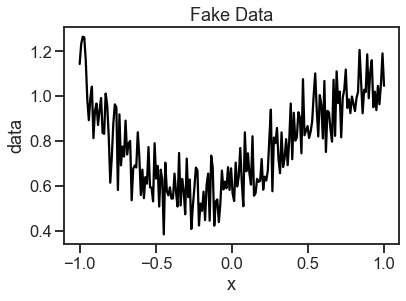

In [196]:
n = 200 # the number of data points
m = 4 # the order of our polynomial
x = np.linspace(-1, 1, n)
A = np.vstack([x**idx for idx in range(m)]).T

# In this step, I'm going to make some fake data for us to fit
true_w = np.random.normal(size=m)
data = A.dot(true_w) + np.random.normal(0, 0.1, size=x.shape[0])

fig, ax = plt.subplots()
plt.plot(x, data, c='k')
ax.set(xlabel='x', ylabel='data', title='Fake Data')

I generated this data with a matrix $\mathbf A$ and randomly generated some "true" value for $\mathbf w$. Now we'd like to solve the equation 

$\mathbf y = \mathbf A \cdot \mathbf w$

There are lots of ways to solve sets of linear equations, and I recommend you take a quick look at this point at [Python Programming and Numerical Methods - A Guide for Engineers and Scientists "Solutions to Systems of Linear Equations" section](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter14.04-Solutions-to-Systems-of-Linear-Equations.html)) for some examples of how this "solving" happens.

Luckily for us, `numpy` has built in some of the solvers that are discussed above! We can use the `solve` function! `solve` will use methods such as LU decomposition to find $\mathbf{w}$ given $\mathbf{A}$ and $\mathbf{y}$

In [197]:
np.linalg.solve(A, data)

LinAlgError: Last 2 dimensions of the array must be square

Oh dear. No we can't.

We can't solve this system of equations as we've written it because $\mathbf A$ is not square. All the methods above A to be square. We're going to have to try to do something else.

### The Normal equation

Let's unpack what we're trying to do. We have a "hypothesis" function, some function that will give us a possible set of values to fit our data. Our hypothesis is a function of guess weights

$\mathbf \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \\ .. \\ \theta_n \end{bmatrix}$

and input regressor vectors column vectors

$\mathbf{X} = \begin{bmatrix}\mathbf x_0 & \mathbf x_1 &\mathbf x_2 & .. & \mathbf x_n  \end{bmatrix} = \begin{bmatrix} x_{0,0} & x_{0,1} & x_{0,2} & .. & x_{0,n} \\
x_{1,0} & x_{1,1} & x_{1,2} & .. & x_{1,n} \\
x_{2,0} & x_{2,1} & x_{2,2} & .. & x_{2,n} \\
.. & .. & .. & .. & .. \\
x_{m,0} & x_{m,1} & x_{m,2} & .. & x_{m,n} \\\end{bmatrix} $

Written out as an equation the hypothesis function is

$h(\theta) = \theta_0 \mathbf x_0 + \theta_1 \mathbf x_1 + \theta_2 \mathbf x_2...+ \theta_n \mathbf x_n$

The residuals between our data $\mathbf y$ and our hypothesis function is given as $\mathbf{y}$ - $\mathbf{h}_\theta(\mathbf x)$. **To find the best fitting model, we would like to minimize these residuals to fit our model.** (The best fitting model is just the model with the smallest difference to the data, i.e. the smallest residuals.) As is commonly done, we're going to minimize the square of the residuals to find the best fitting model. To do this, we have some cost function

$J(\boldsymbol \theta) = \frac{1}{2n}\sum_{i=1}^m (y_i$ - $h_\theta(x_i))^2$

where $m$ is the number of samples (i.e. how many data points we have) and n is the number of regressors we have. We'd like to minimize our cost function $J$, as this will give us the $\theta$ that reduces the residuals the most.

In matrix notation the sum of the residuals can then be written as $\mathbf X \cdot \boldsymbol \theta - \mathbf y$. We now need this to be squared (we're finding the minimum value of the square of the residuals as a function of $\theta$). To get the sum of the squared values of this matrix we can take the dot product with it's transpose. Therefore we find that we can rewrite

$J(\boldsymbol \theta) = \sum_{i=1}^m (y_i$ - $h_\theta(x_i))^2 = (\mathbf X \cdot \boldsymbol \theta - \mathbf y)^T\cdot(\mathbf X \cdot \boldsymbol \theta - \mathbf y)$

(I've dropped the $1/2n$, you'll see why shortly.)

Now we know that our cost function is $(\mathbf X \cdot \boldsymbol \theta - \mathbf y)^T\cdot(\mathbf X \cdot \boldsymbol \theta - \mathbf y)$. For any given vector $\boldsymbol \theta$ this result of the above operation will be a single value, the sum of the square residuals.

Let's see what that looks like in the problem we set up above.

In [198]:
print('n:', n)
print('m:', m)

print('first 5 rows of our design matrix:\n', A[:5])

n: 200
m: 4
first 5 rows of our design matrix:
 [[ 1.         -1.          1.         -1.        ]
 [ 1.         -0.98994975  0.98000051 -0.97015125]
 [ 1.         -0.9798995   0.96020303 -0.94090246]
 [ 1.         -0.96984925  0.94060756 -0.91224753]
 [ 1.         -0.95979899  0.92121411 -0.88418038]]


In [199]:
guess_weights = np.random.normal(size=m)

# Below I write the cost function
# (X.dot(theta) - y).T.dot(X.dot(theta) - y)
cost = (A.dot(guess_weights) - data)[:, None].T.dot((A.dot(guess_weights) - data)[:, None])

print("result of cost function:", cost)

result of cost function: [[566.20600005]]


Below I take random guesses at the true weights to fit our data and plot them over the measured data. I color each line by the result of the cost function $J(\boldsymbol \theta)$. You can see that closer guesses have lower values of the cost function.

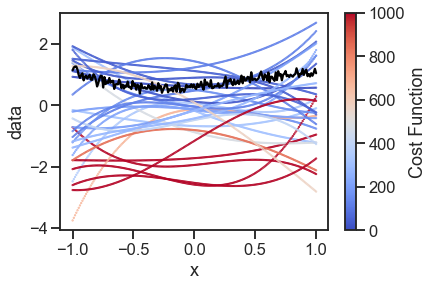

In [200]:
fig, ax = plt.subplots()
ax.plot(x, data, c='k', label='measured data')
ax.set(xlabel='x', ylabel='data')
for count in range(30):
    guess_weights = np.random.normal(size=m)
    cost = (A.dot(guess_weights) - data)[:, None].T.dot((A.dot(guess_weights) - data)[:, None])
    plt.scatter(x, A.dot(guess_weights), c=np.ones(n) * cost[0], vmin=0, vmax=1e3, s=0.5, cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label("Cost Function")

If our guess is close, this number will be close to zero.

But we don't want a function that tells us how close to the answer we are, we want the answer. What's the best fitting weight $\boldsymbol{\theta}$? We have a cost function $J (\boldsymbol \theta)$ as a function of our weights, and we want to find where this is minimized. In otherwords we want to find where:

$\frac{\partial J}{\partial \boldsymbol \theta} = 0$

In other words, we have to take the partial derivative with respect to $\boldsymbol \theta$ of our function

$J (\boldsymbol \theta) = (\mathbf X \cdot \boldsymbol \theta - \mathbf y)^T\cdot(\mathbf X \cdot \boldsymbol \theta - \mathbf y)$

To get this to work, we're going to have to rearrange a little. We can rewrite this as

$J (\boldsymbol \theta) = ((\mathbf X \cdot \boldsymbol \theta)^T - \mathbf y^T)\cdot(\mathbf X \cdot \boldsymbol \theta - \mathbf y)$

and then expand


$J (\boldsymbol \theta) = ((\mathbf X \cdot \boldsymbol \theta)^T \mathbf X \cdot \boldsymbol \theta) - ((\mathbf X \cdot \boldsymbol \theta)^T \cdot \mathbf y) - (\mathbf y^T \cdot (\mathbf X \cdot \boldsymbol \theta)) + \mathbf y^T \cdot \mathbf y$

$(\mathbf X \cdot \boldsymbol \theta)$ and $\mathbf y$ are vectors (and so order of operations does not matter) so we can simplify this further into

$J (\boldsymbol \theta) = \boldsymbol \theta^T  \cdot\mathbf X^T \cdot \mathbf X \cdot \boldsymbol \theta - 2(\mathbf X \cdot \boldsymbol \theta)^T \cdot \mathbf y + \mathbf y^T \cdot \mathbf y$

Taking our partial derivative


$\frac{\partial J}{\partial \boldsymbol \theta} = 2 \cdot\mathbf X^T \cdot \mathbf X \cdot \boldsymbol \theta - 2\mathbf X^T \cdot \mathbf y$

And then to find the minimum of this function we set this to 0

$\frac{\partial J}{\partial \boldsymbol \theta} = 2 \cdot\mathbf X^T \cdot \mathbf X \cdot \boldsymbol \theta - 2\mathbf X^T \cdot \mathbf y = 0$

$2 \cdot\mathbf X^T \cdot \mathbf X \cdot \boldsymbol \theta = 2\mathbf X^T \cdot \mathbf y$

$\cdot\mathbf X^T \cdot \mathbf X \cdot \boldsymbol \theta = \mathbf X^T \cdot \mathbf y$

We can multiply both sides by $(\mathbf X^T \mathbf X)^{-1}$ in order to find $\boldsymbol \theta$ 

$\boldsymbol \theta = (\mathbf X^T \cdot \mathbf X)^{-1} \cdot  \mathbf X^T \cdot \mathbf y$

This is the so called "normal equation". Solving this will result in the best fitting weights for our system.


## Solving in `numpy`
Let's do this for our toy problem above.

To find our weights $\boldsymbol w$ we can write the normal equation as

$\boldsymbol w \cdot (\mathbf A^T \cdot \mathbf A) = \cdot  \mathbf A^T \cdot \mathbf y$

Now we can use the `numpy.linalg.solve` function, because $ (\mathbf A^T \cdot \mathbf A)$ is a square matrix.`numpy.linalg.solve` will solve systems like the ones below to find $\mathbf w$. We need to pass in a matrix and a vector. We can pass this into `numpy.linalg.solve` to solve using LU decomposition:

In [201]:
best_fitting_w = np.linalg.solve(A.T.dot(A), A.T.dot(data))

In [202]:
best_fitting_w

array([ 0.61393947,  0.36058053,  0.49488395, -0.40955047])

Done! We've found our best fitting weights, let's plot them.

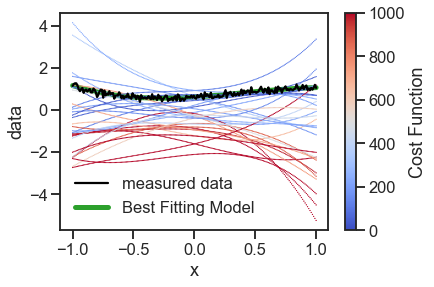

In [203]:
fig, ax = plt.subplots()
ax.plot(x, data, c='k', label='measured data')
ax.set(xlabel='x', ylabel='data')
for count in range(30):
    guess_weights = np.random.normal(size=m)
    cost = (A.dot(guess_weights) - data)[:, None].T.dot((A.dot(guess_weights) - data)[:, None])[0]
    plt.scatter(x, A.dot(guess_weights), c=np.ones(n) * cost, vmin=0, vmax=1e3, s=0.5, cmap='coolwarm', lw=0.5)
cbar = plt.colorbar()
cbar.set_label("Cost Function")

# Best fitting weights:
plt.plot(x, A.dot(best_fitting_w), color='C2', label='Best Fitting Model', lw=5, zorder=-1)
plt.legend()

We can also look at the cost function for our best fitting weights, and see it is small:

In [204]:
(A.dot(best_fitting_w) - data)[:, None].T.dot((A.dot(best_fitting_w) - data)[:, None])[0]

array([1.82887158])

And that's it! We built a model, and we fit it to our data. 

Now, you've derived and are comfortable with **Ordinary Least Squares regression (OLS)**. Nice work!

# Model predictions

Now we've created a design matrix and fit to find the weights, we have a model that can provide us with **predictions** for what the data should be at any point, so long as we can create the equivalent design matrix! 

In the case above, our design matrix $\mathbf{A}$ is just a polynomial in time, let's look at the data compared to the model:

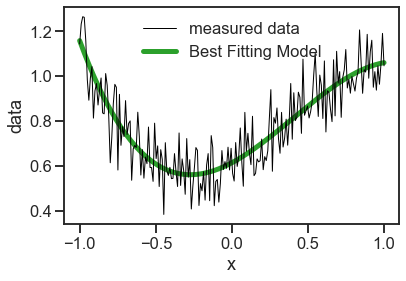

In [206]:
fig, ax = plt.subplots()
ax.plot(x, data, c='k', label='measured data', lw=1)
ax.set(xlabel='x', ylabel='data')
ax.plot(x, A.dot(best_fitting_w), color='C2', label='Best Fitting Model', lw=5, zorder=-1)
ax.legend()

Let's see what the model predicts **outside of this range!**

In [211]:
x2 = np.arange(-1.2, -1, 0.01)
A2 = np.vstack([x2**idx for idx in range(m)]).T
model_prediction = A2.dot(best_fitting_w)

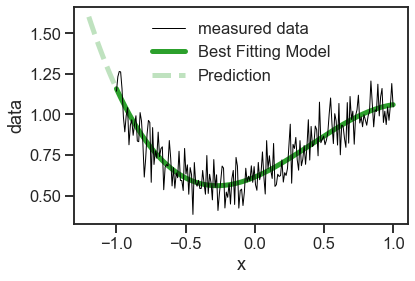

In [216]:
fig, ax = plt.subplots()
ax.plot(x, data, c='k', label='measured data', lw=1)
ax.set(xlabel='x', ylabel='data')
ax.plot(x, A.dot(best_fitting_w), color='C2', label='Best Fitting Model', lw=5, zorder=-1)
ax.plot(x2, model_prediction, color='C2', alpha=0.3, ls='--', label='Prediction', lw=5, zorder=-1)
ax.legend()

Now that we've found the weights, so long as we have values for each dimension of the model (here the only dimension is time) we can use those weights to create a model prediction at that location. Pretty handy, right?

## Using this in real life

Now we've shown we can fit some model to data, let's try a real world example, with real astronomy data. For our real data, let's grab some time series. Here I'll use time series from the Kepler mission, because it's easy to access and pretty easy to understand.

**Note:** For now, we've only derived a way to fit a proposed **linear model** to data, but we haven't figured out how to include errors on the data. We'll come to that soon. 

In [120]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [218]:
lc = lk.search_lightcurve('Kepler-10', mission='Kepler', quarter=10, exptime=1800).download()

Above, I've downloaded data for the target "Kepler-10", which is a famous star from the Kepler mission. This star has a planet transiting around it. The time-series data here is just the brightness of the target over time. We can grab the data out of this Python object. I will use only the first 1000 elements as an example.

**Note:** `lc` is a `lightkurve` object, which you might already know how to work with. For the purposes of this tutorial, I'm just going to take the time and flux components from this object and work with them as `numpy` arrays.

In [219]:
x, y = lc.remove_nans().time.value[:1000], np.asarray(lc.remove_nans().normalize().flux.value)[:1000]
x -= x.mean()

In [220]:
x[:5]

array([-10.33453882, -10.31410481, -10.29367069, -10.27323678,
       -10.25280277])

In [221]:
y[:5]

array([1.0002722, 1.0003943, 1.0003676, 1.0004128, 1.0004009],
      dtype=float32)

Now we have the array of times `x` and the array of flux values `y`. Let's plot them below.

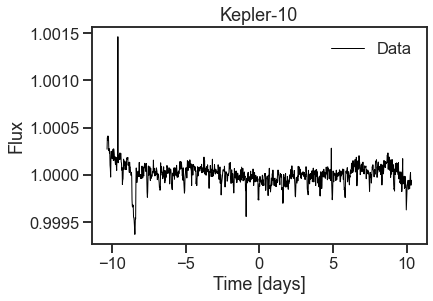

In [222]:
fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Great. In the above data, we can see lots going on. Firstly we see that there is a large dip in flux around time -11. This is because a planet has transited the star, blocking some of the light, and reducing the flux. We also see that there is a repeating signal where the flux drops sharply every ~0.7 days. This is a second planet in the system!

We also see that there is some sort of long term trend in the data.

Let's assume here that we're trying to remove the long term trend, so we can learn more about those transits.

**Let's build ourselves a linear model!**

We'll start simple. We're going to use another **polynomial**. We're trying to fit time series, so we want a model that is a **polynomial in time**. 

Let's start there.

Step one. We're going to need a **design matrix**. We know we want our model to take the form of:

$\mathbf{y} = w_0*\mathbf{t}^0 + w_1*\mathbf{t}^1 + w_2*\mathbf{t}^2$

i.e. 

$\mathbf{y} = w_0 + w_1*\mathbf{t} + w_2*\mathbf{t}^2$

Where $\mathbf{t}$ is a vector of times, and $w_0$, $w_1$ and $w_2$ are single valued elements of a vector of weights $\mathbf{w}$.

We can write this as

$\mathbf{y} = \mathbf{A} \cdot \mathbf{w}$

where $\mathbf{A}$ is a design matrix made up of the column vectors $\mathbf{t}^0, \mathbf{t}^1, \mathbf{t}^2$ and $\mathbf{w}$ is a vector with three elements (i.e. the weights).

Let's build that matrix.

In [223]:
A = np.vstack([(x) ** idx for idx in range(3)]).T

In [224]:
A

array([[  1.        , -10.33453882, 106.80269269],
       [  1.        , -10.31410481, 106.38075801],
       [  1.        , -10.29367069, 105.95965637],
       ...,
       [  1.        ,  10.28330221, 105.7463043 ],
       [  1.        ,  10.30373605, 106.16697658],
       [  1.        ,  10.32416999, 106.588486  ]])

Above we've made the columns vector $\mathbf{t}^0, \mathbf{t}^1, \mathbf{t}^2$ and used `vstack` and the transpose operation to turn them into a tall design matrix with shape

In [225]:
A.shape

(1000, 3)

## Note: Whitening vectors

Above you'll see that I could have done

```A = np.vstack([x ** idx for idx in range(3)]).T```

And you will also see that I have removed the mean value from the `x` vector, so that the mean is 0.

In [226]:
x.mean()

1.1823431123048067e-14

In most cases, if we can, we ideally want to "whiten" the vectors we are using. Whitenined here means making the vectors have mean 0, and ideally standard deviation of 1. 

If I were trying to do a 20th order polynomial in `x`, and I was trying to do ```x^20``` I might find:

1. For large positive or negative numbers, I might struggle with machine precision
2. When trying to fit linear models with vectors that have extremely large (e.g. 1e100) or extremely small values (e.g. 1e-100) machine precision problems will compound and I can get odd answers.

Because of this, if I'm building a design matrix like the one above, it's good practice to "whiten" the vectors before hand. I would do that using something like:

```A = np.vstack([((x - x.mean())/x.std()) ** idx for idx in range(3)]).T```

In this instance, I'm not going to do this, because it will make things more legible, and because I already know for these vectors, even if I take them to large powers, they are still pretty small numbers. But, if you're having problems in your own model, it won't hurt to take a look at the values that are in A, and see if you're trying to fit a matrix that has a lot of very large and/or very small values.

Now we have our design matrix $\mathbf{A}$ and we have our data $\mathbf{y}$, we just need to fit to find the best fitting weights $\mathbf{w}$. That's easy now we've derived our OLS equation above:

In [227]:
w = np.linalg.solve(A.T.dot(A), A.T.dot(y))
w

array([ 9.99974089e-01, -2.69034712e-06,  9.58978925e-07])

Easy! Let's take a look at the model. Remember to get the best fitting model we can now just take the dot product of our design matrix with our weights:
$\mathbf{A}\cdot\mathbf{w}$

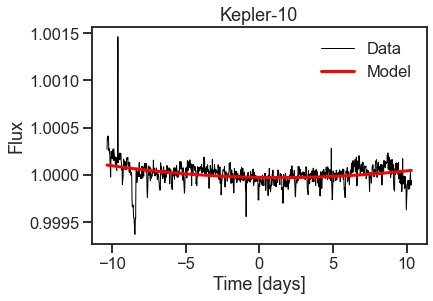

In [228]:
fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.plot(x, A.dot(w), lw=3, label='Model', c='r')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Looks great! We've got a model that fits our data, and it looks fairly accurate! It's capturing the high level trend of the data.

However, we've built a very simple model. In this model, there's not the flexibility we need to capture finer detail. How can we improve that? Here are some ideas.

### Idea 1: We could increase the complexity of the model

This is done easily, we could increase the polynomial order of the model to try to capture more of the variability. Let's do that quickly:

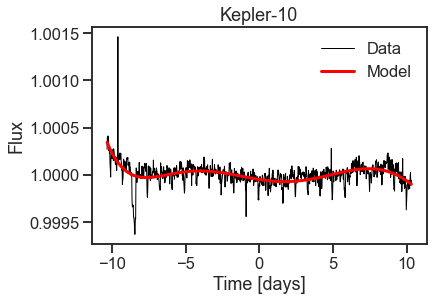

In [229]:
# 7th order polynomial
A = np.vstack([(x) ** idx for idx in range(7)]).T
w = np.linalg.solve(A.T.dot(A), A.T.dot(y))

fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.plot(x, A.dot(w), lw=3, label='Model', c='r')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Ok! A more complex polynomial is a better fit!

This is ok, and we're not taking the polynomial order very high, but let's just think critically for a second about what we're doing here...

Here we have set up a model that says "at **any** point in time, I can predict the flux of the star from just these weights $\mathbf{w}$." Do we think it's likely that these same weights hold for all times? For 1st or 2nd order polynomial orders, that might be fairly true; if the star has a brightness around 1 now, it'll probably have a brightness around 1 at any time.

But as we increase the polynomial order too high, our prediction for other times probably explodes quickly...Let's check. Let's make up some other times, and see what our model predicts.

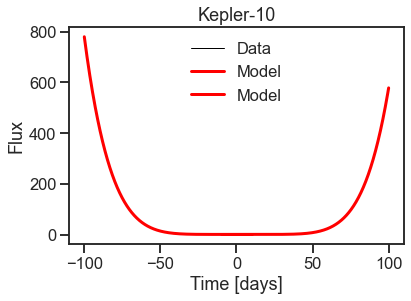

In [231]:
# 7th order polynomial
x2 = np.linspace(-100, 100, 1000)
A2 = np.vstack([(x2) ** idx for idx in range(7)]).T

fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.plot(x, A.dot(w), lw=3, label='Model', c='r')
ax.plot(x2, A2.dot(w), lw=3, label='Model', c='r')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Hmm. This model has blown up pretty quickly on either side of our data. Looking at this as scientists, we already know this isn't correct. The underlying physical process probably **isn't** well described by a 7th order polynomial, because astrophysically this target is not likely to increase in brightness by factors of 100 over a few days. 

It is, however, a convenient and easy model. You might want to use such a model often, to capture for example some nuisance trend in your data. In this case, we're doing it to remove stellar variability so we can see transits, and there are cases where it's safe to do this! However, you should always keep in mind the limitations of your model, and in this case, the limitation is that it is not likely to be a good predictive model far from the data range. 

### Idea 2: We could change the model

Instead of making this a polynomial, which is probably not a very accurate representation of the data, we could instead build a different model. Let's try doing something like that, and let's draw from our astrophysics background.

We know this is a star, and we know stars rotate, and can have periodic behavior. Let's propose a sinusoid is a good fit for the data.

Take a look at the below model 

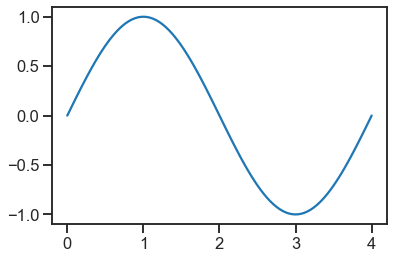

In [279]:
x = np.linspace(0, 4, 100)
period = 4
plt.plot(x, np.sin(x * (2 * np.pi)/period))

Above is the curve $sin(\frac{2x\pi}{P})$ where $P$ is the period of the curve. If we want to make a model where **$P$ is a variable** in our model, this **cannot be a linear model** because it is inside the $sin$ function. There is no way for us to tune the period $P$ in this model by multiplying by a coefficient.

Multiplying by a coefficient will only change the amplitude of the curve:

$w_0 sin(\frac{2x\pi}{P})$

So what do we do? In a case where we happen to know a period, we can use a linear model to find the best fitting amplitude of the sinusoid, but we can't use a linear model to find the best fitting period.

For now, we're going to say this isn't a good model to achieve what we want, but in future we'll return to this.

### Idea 3: What if we could use a piecewise polynomial

### Idea 4: There must be a better way.

There actually is a better way than this, but to get to that point we're going to have to go back to the drawing board, and we're going to have start understanding **errors**. Let's get into that below.

# Adding noise to our model: Weighted Least Squares regression

Noise is important in our applications. Sometimes I have measurements of stellar flux from different telescopes, or different times and I know they have different noise properties. Sometimes I have spectra that are noisier at particular wavelengths. It's important to be able to fold that information into our model. Let's start down this path.

Let's make our dataset again, but this time, let's add some noisier data. This might happen because of some measurement error.

[Text(0.5, 0, 'x'), Text(0, 0.5, 'data'), Text(0.5, 1.0, 'Fake Data')]

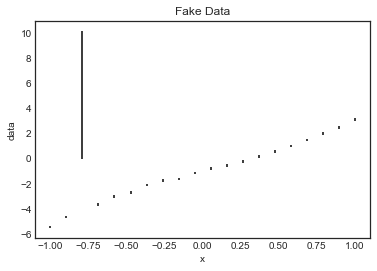

In [73]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

n = 20 # the number of data points
m = 4 # the order of our polynomial
x = np.linspace(-1, 1, n)
A = np.vstack([x**idx for idx in range(m)]).T

# In this step, I'm going to make some fake data for us to fit
true_w = np.random.normal(size=m)
data = A.dot(true_w) + np.random.normal(0, 0.1, size=x.shape[0])
error = np.ones(x.shape[0]) * 0.1

bad_idx = np.random.choice(np.arange(n), 1)
data[bad_idx] += np.random.normal(0, 5, size=1)
error[bad_idx] += 5

fig, ax = plt.subplots()
plt.errorbar(x, data, error, c='k', ls='')
ax.set(xlabel='x', ylabel='data', title='Fake Data')

**Note:** In this scenario, you **know** the noise for each data point. And you **know** the errors on those outlier datapoints. We'll touch on this again soon.

If we use OLS regression, which doesn't take into account these measurement errors, we're now going to get the wrong answer.

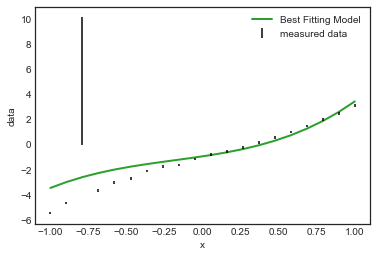

In [74]:
fig, ax = plt.subplots()
ax.errorbar(x, data, error, ls='', c='k', label='measured data')
ax.set(xlabel='x', ylabel='data')
best_fitting_w = np.linalg.solve(A.T.dot(A), A.T.dot(data))
# Best fitting weights:
plt.plot(x, A.dot(best_fitting_w), color='C2', label='Best Fitting Model', lw=2, zorder=-1)
plt.legend()

In the above example, we have a dataset with lots of well estimated datapoints (small errors) and one large outlier with a huge uncertainty. That one outlier (which we know to have a larger uncertainty) is pulling our solution to one side, because all the points have equal weights.

Instead of weighting all the points equally, we can instead have the weight of each point be given by our uncertainty in that measurement. We're going to weight each point by the inverse variance. We assume here that the "errors" reported with our data are the standard deviation, so the inverse variance for the $i$th point is $\frac{1}{\sigma_i^2}$. Weighting our cost function from the OLS derivation above, we can find a new cost function:

$J(\boldsymbol \theta) = \frac{1}{2n}\sum_{i=1}^m \frac{1}{\sigma_i^2} (y_i$ - $h_\theta(x_i))^2$


# Adding more robust noise to the model: Generalized Least Squares regression 

We've already understood how to add something like measurement errors to our model, but this isn't the end of adding noise. Let's learn how to add the missing piece; covariance. But, to do that, we'll need to talk about what covariance is first.

## Covariance

Covariance is a measure of whether two variables "vary" together. Variables are "covariant" if they both go up or both go down at the same time. 

In [13]:
a, b = np.random.normal(size=(2, 100))

[Text(0.5, 0, 'a'), Text(0, 0.5, 'b')]

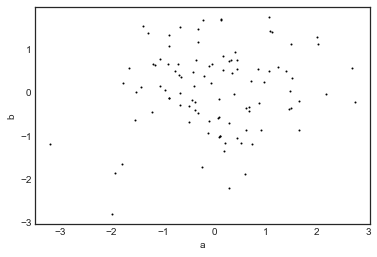

In [14]:
fig, ax = plt.subplots()
plt.scatter(a, b, c='k', s=1)
ax.set(xlabel='a', ylabel='b')

Covariance between two vectors $\mathbf x$ and $\mathbf y$ is given as

$\frac{1}{n}\sum^n_{i=0}(x_i  - \mathbf{\hat{x}})(y_i  - \mathbf{\hat{y}})$

where the hat symbol denotes the mean of the vector. If we look at the covariance for a and be we find a number very close to 0

In [15]:
np.sum((a - np.mean(a)) * (b - np.mean(b)))/len(a)

0.12470598245769468

In other words, they aren't covariant. Let's make a vector that is covariant

In [16]:
c = b + a * 1 + np.random.normal(size=(100))

[Text(0.5, 0, 'a'), Text(0, 0.5, 'c')]

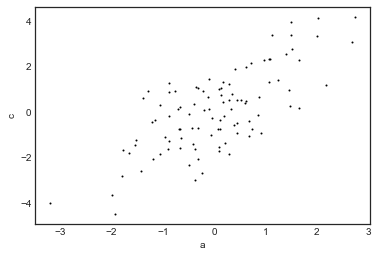

In [17]:
fig, ax = plt.subplots()
plt.scatter(a, c, c='k', s=1)
ax.set(xlabel='a', ylabel='c')

This time the covariance is a positive value much greater than 1, these are covariant vectors

In [18]:
np.sum((a - np.mean(a)) * (c - np.mean(c)))/len(a)

1.3641776341898577

Note that the "variance" of a vector is the covariance of the vector with itself!

### Covariance Matrix

In our case, we don't have just two vectors, we have a large number of vectors in our design matrix. If we want to know the covariance of each of our column vector regressors with each other, we can create a covariance matrix. 

In [19]:
X = np.vstack([a, b, c]).T

In [20]:
cov = (X - X.mean(axis=0)).T.dot((X - X.mean(axis=0)))/X.shape[0]

This will take the form

$\begin{bmatrix}
cov(a, a) &cov(a, b) &cov(a, c) \\
cov(b, a) &cov(b, b) &cov(b, c) \\
cov(c, a) &cov(c, b) &cov(c, c) \\
\end{bmatrix}$

or another way

$\begin{bmatrix}
var(a) &cov(a, b) &cov(a, c) \\
cov(b, a) &var(b) &cov(b, c) \\
cov(c, a) &cov(c, b) &var(c) \\
\end{bmatrix}$

In [21]:
cov

array([[1.14536886, 0.12470598, 1.36417763],
       [0.12470598, 0.87748305, 0.85642741],
       [1.36417763, 0.85642741, 3.06754659]])

You can see the variance of each vector in the diagonal, and the covariance of each vector pair in the off diagnoal terms.

### What do these matrices mean...?

Before we move on, let's just look at what different versions of this matrix would mean:

A covariance matrix like this
$\begin{bmatrix}
1 &0 &0 \\
0 &1 &0 \\
0 &0 &1 \\
\end{bmatrix}$

means that the input vectors **are uncorrelated**, because the off diagonal terms are 0. The **variance** of the vectors are the same, because the diagonal values are all the same.

A covariance matrix like this
$\begin{bmatrix}
3 &0 &0 \\
0 &1 &0 \\
0 &0 &2 \\
\end{bmatrix}$

means that the input vectors are uncorrelated and each vector has **different variance** because the diagonal terms are different. 

A covariance matrix like this
$\begin{bmatrix}
1 &0.2 &0.3 \\
0.2 &1 &0.4 \\
0.3 &0.4 &1 \\
\end{bmatrix}$

means that the vectors **are correlated**, and they have the same variance. 

### Covariance with weights

Frequently we have data with different weights. If we want to include errors in our covariance estimate, we can do so by weighting the covariance using those errors:

$cov(\mathbf x, \mathbf y) = \frac{1}{n}\sum^n_{i=0}\frac{(x_i  - \mathbf{\hat{x}})(y_i  - \mathbf{\hat{y}})}{\sigma_{x_i}\sigma_{y_i}}$

where $\sigma_{x_i}$ indicates the error on the $i$th element in the vector $\mathbf x$.

Let's make our data again, and this time, let's add a few outliers with larger errors

In [22]:
a, b = np.random.normal(0, 0.01, size=(2, 100))
c = b + a * 0.5 + np.random.normal(0, 0.1, size=(100))
bad_idx = np.random.choice(np.arange(100), 5)
a[bad_idx] += np.random.normal(0, 0.2, size=5)
b[bad_idx] += np.random.normal(0, 0.2, size=5)
c[bad_idx] += np.random.normal(0, 0.2, size=5)
err = np.ones(100) * 0.01
err[bad_idx] = (0.2**2 + 0.01**2)**0.5

Now I've made similar variables as before, but this time I've added five points that have more noise in them.

<ErrorbarContainer object of 3 artists>

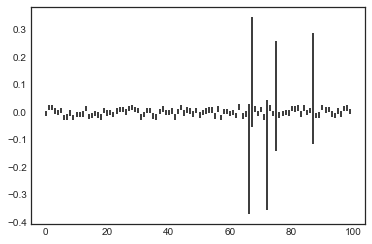

In [23]:
plt.errorbar(np.arange(100), a, err, ls='', c='k')

In [24]:
X = np.vstack([a, b, c]).T

If we assume the vectors all have equal errors we get the following covariance matrix

In [25]:
cov = ((X - X.mean(axis=0))/0.01**2).T.dot(((X - X.mean(axis=0))/0.01**2))/X.shape[0]

In [26]:
cov

array([[  95783.88229264,   81337.25022426,  -70798.84665131],
       [  81337.25022426,  235643.85831875,    8605.45498374],
       [ -70798.84665131,    8605.45498374, 1455636.98094312]])

This is incorrect, the values are very large, and the data has huge variance. 


If we assume the vectors have their correct errors we get

In [29]:
cov = (X - X.mean(axis=0)/err[:, None]**2).T.dot((X - X.mean(axis=0)/err[:, None]**2))/X.shape[0]

In [30]:
cov

array([[282.64852642, 295.53200061, 441.72290515],
       [295.53200061, 309.00441942, 461.85829911],
       [441.72290515, 461.85829911, 690.34329881]])

This is much better behaved and reflects the covariance of the data much more accurately.

# Working with Multiple Dimensions

### What's a singular matrix?

A matrix can have an inverse. If I have a matrix $\mathbf M$ with an inverse $\mathbf M^{-1}$, if I dot them with each other I get back the identity matrix. Note that $\mathbf M$ must be a square matrix.

$\mathbf M \cdot \mathbf M^{-1} = \mathbf{I}$

Not all matrices have inverses. 

If your matrix does not have an inverse it is a **singular matrix**. Here's an example of using `numpy` to calculate the inverse of a matrix using `np.linalg.inv`.

In [102]:
M = np.random.normal(size=(4, 4))
M_inv = np.linalg.inv(M)
print(np.round(M.dot(M_inv), 8))

[[ 1. -0.  0. -0.]
 [-0.  1.  0. -0.]
 [-0. -0.  1.  0.]
 [-0.  0.  0.  1.]]


Let's try to find the invert of a matrix that is all ones:

In [105]:
np.ones((4, 4))

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [106]:
M = np.ones((4, 4))
M_inv = np.linalg.inv(M)

LinAlgError: Singular matrix

And `numpy` throws an error for us, telling us the matrix is singular.

There is no inverse for this matrix, there's no matrix that can be dotted with $\mathbf M$ to return the identity. Another way to show this is to calculate the **determinant** of $\mathbf M$, which is a property of the matrix. If the determinant is 0, there is no inverse for that matrix, and it is singular.

In [110]:
np.linalg.det(M)

0.0

### What is matrix rank?

Matrix rank is a very useful. It tells us how many of our columns or rows in our matrix are independent. If you have a matrix with rank equal to the smallest dimension of your matrix (i.e. in a `4x3` matrix or a `3x4` matrix that would be `3`) then you have a **full rank** matrix. This would mean all of the rows and columns are linearly independent of each other.

In our context, a matrix of regressors with rank equal to the number of columns, then all the regressors are linearly independent. 

Below we have a matrix of ones with shape `4x3`. It has rank 1 because the rows are all linearly dependent (in fact they are identical)

In [125]:
M = np.ones((4, 3))
print(M)
print('rank:', np.linalg.matrix_rank(M))

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
rank: 1


Similarly a matrix with columns of 1s, 2s and 3s has rank 1 because they can all be specified by the same vector multiplied by different scalar weights.

In [127]:
M = np.ones((4, 3)) * [1, 2, 3]
print(M)
print('rank:', np.linalg.matrix_rank(M))

[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
rank: 1


If we instead make a matrix with ones and zeros in different locations, we find a rank 3 matrix, which is a full rank matrix. All of these rows are linearly independent.

In [137]:
M = np.diag(np.ones(4))[:, :-1]
print(M)
print('rank:', np.linalg.matrix_rank(M))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
rank: 3
